# Animations showing feature space and classification boundaries

While dtreeviz is dedicated primarily to showing decision trees, we have also provided a way to show the decision boundaries for one- and two- variable classifiers. The `clfviz()` function will work with any model that answers method `predict_proba()` and with Keras, for which we provided a special adapter (since that method is deprecated).

Using a silly little `pltvid` library I built, we can do some simple animations.  I think it doesn't work on Windows because I directly relied on `/tmp` dir. Sorry.

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
%config InlineBackend.figure_format = 'svg'  # Looks MUCH better than retina
# %config InlineBackend.figure_format = 'retina'

from rfpimp import *   # pip install rfpimp

from sklearn import tree

import dtreeviz
from dtreeviz import clfviz

## Wine data set

In [2]:
wine = load_wine()
X = wine.data
X = X[:,[12,6]]
y = wine.target

In [3]:
rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=20, n_jobs=-1)
rf.fit(X, y)

RandomForestClassifier(min_samples_leaf=20, n_estimators=50, n_jobs=-1)

In [4]:
! pip install --quiet -U pltvid  # simple animation support by parrt

In [5]:
import pltvid

dpi = 300
camera = pltvid.Capture(dpi=dpi)
max = 10
for depth in range(1,max+1):
    t = DecisionTreeClassifier(max_depth=depth)
    t.fit(X,y)

    fig,ax = plt.subplots(1,1, figsize=(4,3.5), dpi=dpi)
    clfviz(t, X, y, 
           feature_names=['proline', 'flavanoid'], target_name="wine",
           ax=ax)
    plt.title(f"Wine tree depth {depth}")
    plt.tight_layout()
    if depth>=max:
        camera.snap(8)
    else:
        camera.snap()
    # plt.show()

camera.save("wine-dtree-maxdepth.png", duration=500) # animated png

## Synthetic data set

In [6]:
def smiley(n = 1000):
    # mouth
    x1 = np.random.normal(1.0,.2,n).reshape(-1,1)
    x2 = np.random.normal(0.4,.05,n).reshape(-1,1)
    cl = np.full(shape=(n,1), fill_value=0, dtype=int)
    d = np.hstack([x1,x2,cl])
    data = d
    
    # left eye
    x1 = np.random.normal(.7,.2,n).reshape(-1,1)
#     x2 = np.random.normal(0.8,.1,n).reshape(-1,1)
    x2 = x1 + .3 + np.random.normal(0,.1,n).reshape(-1,1)
    cl = np.full(shape=(n,1), fill_value=1, dtype=int)
    d = np.hstack([x1,x2,cl])
    data = np.vstack([data, d])

    # right eye
    x1 = np.random.normal(1.3,.2,n).reshape(-1,1)
    x2 = np.random.normal(0.8,.1,n).reshape(-1,1)
    x2 = x1 - .5 + .3 + np.random.normal(0,.1,n).reshape(-1,1)
    cl = np.full(shape=(n,1), fill_value=2, dtype=int)
    d = np.hstack([x1,x2,cl])
    data = np.vstack([data, d])

    # face outline
    noise = np.random.normal(0,.1,n).reshape(-1,1)
    x1 = np.linspace(0,2,n).reshape(-1,1)
    x2 = (x1-1)**2 + noise
    cl = np.full(shape=(n,1), fill_value=3, dtype=int)
    d = np.hstack([x1,x2,cl])
    data = np.vstack([data, d])

    df = pd.DataFrame(data, columns=['x1','x2','class'])
    return df

Test we get 4 classes in a smiley face:

### Animate num trees in RF

In [7]:
! pip install --quiet -U pltvid

In [8]:
import pltvid

df = smiley(n=100)
X = df[['x1','x2']]
y = df['class']
rf = RandomForestClassifier(n_estimators=10, min_samples_leaf=1, n_jobs=-1)
rf.fit(X, y)

dpi = 300
camera = pltvid.Capture(dpi=dpi)
max = 100
tree_sizes = [*range(1,10)]+[*range(10,max+1,5)]
for nt in tree_sizes:
    np.random.seed(1) # use same bagging sets for animation
    rf = RandomForestClassifier(n_estimators=nt, min_samples_leaf=1, n_jobs=-1)
    rf.fit(X, y)

    fig,ax = plt.subplots(1,1, figsize=(3,2.8), dpi=dpi)
    clfviz(rf, X.values, y, feature_names=['x1', 'x2'],
                 ntiles=70, dot_w=15, boundary_markersize=.4, ax=ax)
    plt.title(f"Synthetic dataset, {nt} trees")
    plt.tight_layout()
    if nt>=tree_sizes[-1]:
        camera.snap(5)
    else:
        camera.snap()
    # plt.show()

camera.save("smiley-numtrees.png", duration=500)

### Animate decision tree max depth

In [9]:
import pltvid

df = smiley(n=100) # more stark changes with fewer
X = df[['x1','x2']]
y = df['class']

dpi = 300
camera = pltvid.Capture(dpi=dpi)
max = 10
for depth in range(1,max+1):
    t = DecisionTreeClassifier(max_depth=depth)
    t.fit(X,y)

    fig,ax = plt.subplots(1,1, figsize=(4,3.5), dpi=dpi)
    clfviz(t, X, y, 
               feature_names=['x1', 'x2'], target_name="class",
               show={'splits'},
               colors={'scatter_edge': 'black',
                       'tesselation_alpha':.6},
               ax=ax)
    plt.title(f"Synthetic dataset, tree depth {depth}")
    plt.tight_layout()
    if depth>=max:
        camera.snap(8)
    else:
        camera.snap()
    # plt.show()

camera.save("smiley-dtree-maxdepth.png", duration=500)

### Animate decision tree min samples per leaf

In [10]:
import pltvid

df = smiley(n=100)
X = df[['x1','x2']]
y = df['class']

dpi = 300
camera = pltvid.Capture(dpi=dpi)
max = 20
for leafsz in range(1,max+1):
    t = DecisionTreeClassifier(min_samples_leaf=leafsz)
    t.fit(X,y)

    fig,ax = plt.subplots(1,1, figsize=(4,3.5), dpi=dpi)
    clfviz(t, X, y, 
               feature_names=['x1', 'x2'], target_name="class",
               show={'splits'},
               colors={'scatter_edge': 'black',
                       'tesselation_alpha':.4},
               ax=ax)
    plt.title(f"Synthetic dataset, {leafsz} samples/leaf")
    plt.tight_layout()
    if leafsz>=max:
        camera.snap(8)
    else:
        camera.snap()
    # plt.show()

camera.save("smiley-dtree-minsamplesleaf.png", duration=500)

# One-dimensional classifier plots

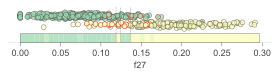

In [11]:
cancer = load_breast_cancer()

df = pd.DataFrame(data=cancer.data)
df.columns = [f'f{i}' for i in range(df.shape[1])]
df['y'] = cancer.target

x = df['f27']
y = df['y']

rf = RandomForestClassifier(n_estimators=10, min_samples_leaf=1)
rf.fit(x.values.reshape(-1,1), y)

clfviz(rf,x,y,feature_names=['f27'])
plt.tight_layout()

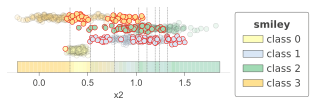

In [12]:
df = smiley(n=200)
x = df[['x2']].values
y = df['class'].astype('int').values
rf = RandomForestClassifier(n_estimators=10, min_samples_leaf=10, n_jobs=-1)
rf.fit(x, y)
clfviz(rf,x,y,
       show=['instances', 'boundaries', 'probabilities', 'misclassified','legend'],
       feature_names=['x2'],
       target_name = 'smiley',
       colors={'scatter_marker_alpha':.2})